# CNN Model

This code is an adaptation of the CNN model provided by Professor Jorge Henriques in the course slides, the CNN model developed for another course (available at https://github.com/leosousa200/RetinopathyAlgorithm), a guide to multi-input CNN provided by Keras (available at https://keras.io/guides/functional_api/) and a CNN model available on Kaggle (at https://www.kaggle.com/code/vishwasgpai/guide-for-creating-cnn-model-using-csv-file/notebook).

### Imports

In [755]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Concatenate

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Data Preprocessing and Organization

In [756]:
numeric = pd.read_csv("COVID_numerics.csv").values
images  = pd.read_csv("COVID_IMG.csv",header=None).values # avoids ignoring first line!

X_num = numeric[:,0:8] # 8 columns (GENDER,AGE,MARITAL STATUS,VACINATION,RESPIRATION CLASS,HEART RATE,SYSTOLIC BLOOD PRESSURE,TEMPERATURE)
T = numeric[:,8] # Target
X_img = images[:,:] # each line represents a 21x21 image

# RULE: IF breathing difficulty >= moderate AND Temperature > 37.8 THEN Stay at hospital (T=1)
T[(numeric[:, 4]>=2) & (numeric[:, 7]>=37.8)] = 1

t0 = np.sum(T==0)
t1 = np.sum(T==1)
print(f"Number of cases with T=0: {t0}")
print(f"Number of cases with T=1: {t1}")

Number of cases with T=0: 359
Number of cases with T=1: 241


### Reshape Image Data (21x21)

In [757]:
X_img = X_img.reshape(X_img.shape[0],21,21,1) # resize images into 21x21x1

### Train-Test Split

In [758]:
X_img_train, X_img_test, X_num_train, X_num_test, T_train, T_test = train_test_split(X_img, X_num, T, test_size=0.3, random_state=42)

### Model

In [759]:
numeric_input = Input(shape=(8,))
image_input = Input(shape=(21,21,1))

# CNN Path Only for the Images
x_img = Conv2D(64, (3, 3), activation='relu')(image_input)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Dropout(0.2)(x_img)
x_img = Conv2D(32, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Dropout(0.2)(x_img)
x_img = Flatten()(x_img)

# MLP Path Only for Numerical Data
x_num = Dense(64, activation='relu')(numeric_input)
x_num = Dropout(0.3)(x_num)
x_num = Dense(32, activation='relu')(x_num) # extra layer to catch more complex relationships between data
x_num = Dropout(0.3)(x_num)
#x_num = Dense(16, activation='relu')(x_num)

# Concatenate Outputs
concatenated = Concatenate()([x_img, x_num])

# Final Output Dense Layer
output = Dense(1,activation='sigmoid')(concatenated) # this is a binary classification problem, so we can use the Sigmoid activation function

model = Model(inputs=[image_input,numeric_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_175     │ (None, 21, 21, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 19, 19,    │        640 │ input_layer_175[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_188   │ (None, 9, 9, 64)  │          0 │ conv2d_195[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_152         │ (None, 9, 9, 64)  │          0 │ max_pooling2d_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_174     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 7, 7, 32)  │     18,464 │ dropout_152[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_266 (Dense)   │ (None, 64)        │        576 │ input_layer_174[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_189   │ (None, 3, 3, 32)  │          0 │ conv2d_196[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_154         │ (None, 64)        │          0 │ dense_266[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_153         │ (None, 3, 3, 32)  │          0 │ max_pooling2d_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_267 (Dense)   │ (None, 32)        │      2,080 │ dropout_154[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_86          │ (None, 288)       │          0 │ dropout_153[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 32)        │          0 │ dense_267[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_86      │ (None, 320)       │          0 │ flatten_86[0][0], │
│ (Concatenate)       │                   │            │ dropout_155[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_268 (Dense)   │ (None, 1)         │        321 │ concatenate_86[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5454 - loss: 3.8425 - val_accuracy: 0.5889 - val_loss: 0.7857
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4738 - loss: 4.1306 - val_accuracy: 0.5889 - val_loss: 0.7712
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5352 - loss: 3.0798 - val_accuracy: 0.5889 - val_loss: 1.0174
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5330 - loss: 2.6409 - val_accuracy: 0.6556 - val_loss: 0.7169
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5473 - loss: 2.3820 - val_accuracy: 0.6778 - val_loss: 0.6824
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5260 - loss: 1.8658 - val_accuracy: 0.6833 - val_loss: 0.7027
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5958 - loss: 1.5505 - val_accuracy: 0.6944 - val_loss: 0.7659
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6149 - loss: 1.3732 - val_accuracy: 0.6722 - val_loss: 0.7236


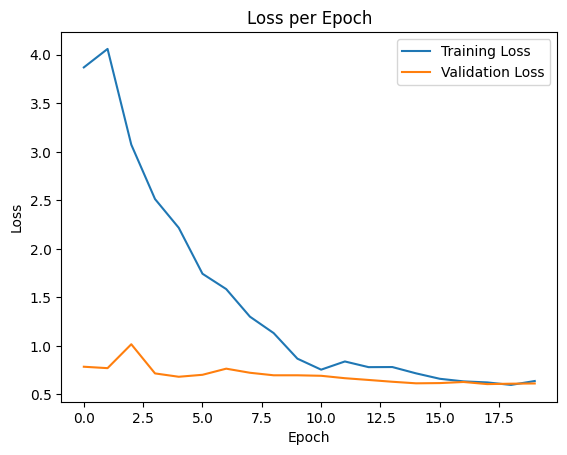

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.80       253
         1.0       0.71      0.60      0.65       167

    accuracy                           0.74       420
   macro avg       0.73      0.72      0.72       420
weighted avg       0.74      0.74      0.74       420



In [760]:
history = model.fit([X_img_train, X_num_train], T_train, epochs=20, batch_size=64, validation_data=([X_img_test, X_num_test], T_test))
print("Loss: ", history.history['loss'])

plt.plot(history.history['loss'], label='Training Loss'), plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

train = model.predict([X_img_train, X_num_train]).round()

print(classification_report(T_train,train))

### Test Model

In [761]:
Ytest = model.predict([X_img_test, X_num_test]).round()
scores = model.evaluate([X_img_test, X_num_test], T_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Baseline Error: 30.56%


### Evaluate Model

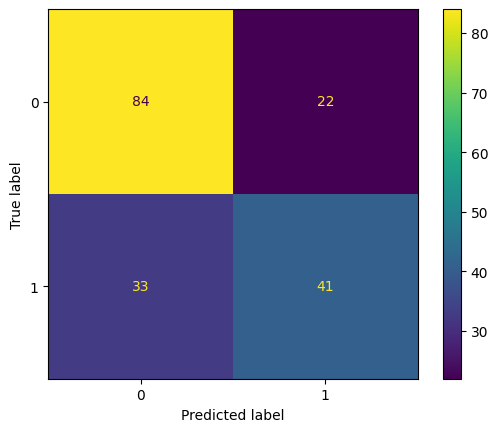

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       106
         1.0       0.65      0.55      0.60        74

    accuracy                           0.69       180
   macro avg       0.68      0.67      0.68       180
weighted avg       0.69      0.69      0.69       180



In [762]:
cm = confusion_matrix(T_test, Ytest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(T_test,Ytest))

### Examples of images from the dataset

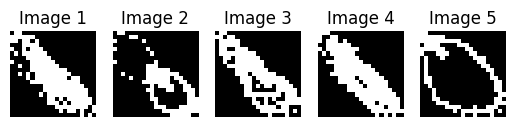

In [763]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_img_train[i].reshape(21, 21), cmap='gray')
    plt.title(f"Image {i+1}"), plt.axis('off')
plt.show()